<a href="https://colab.research.google.com/github/Rob174/Astronomy/blob/Astronomy/AI/FFT000001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fonctions de base

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/TIPE'
import os
from tensorflow.python.client import device_lib
print("Utilise le",str(device_lib.list_local_devices()[0])[15:18])
print()
print()
from google.colab import files
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.layers import Layer
import matplotlib.gridspec as gridspec
from keras.models import Sequential
from keras.layers import Dense, Dropout,concatenate,Subtract,Multiply,Average, Concatenate,Reshape, Add, BatchNormalization
from keras.layers import Reshape,Lambda
from keras.layers.core import Activation
from keras.optimizers import SGD, Adam
from keras import models
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, AveragePooling2D,MaxPooling2D
import keras.losses
from keras.layers.core import Flatten
from keras import backend as K
import numpy as np
import scipy
from PIL import Image
from keras.layers import Input
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
images = ["Galaxies_resized/"+f for f in os.listdir("Galaxies_resized/")]
noises = []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/TIPE
Utilise le CPU




Using TensorFlow backend.


In [0]:
# Install latest Tensorflow build
# !pip install -q tf-nightly-2.0-preview
# from tensorflow import summary
# %load_ext notebookµ

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [4]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
def next_batch(batch_size, images,tailleAttendue,formatArray):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    """
    imageEntreeTensor = []
    imageSortieTensor = []
    while len(imageEntreeTensor) < batch_size:
        try:
            np.random.shuffle(images)#choix aléatoire de l'image
            image = cv2.imread(images[0])#Ouvre en rgb l'image nettoyée
            resizedImage = cv2.resize(image,(tailleAttendue,tailleAttendue))
            imageSortieTensor.append(np.array(resizedImage,dtype=formatArray))
            imageEntreeTensor.append(np.array(resizedImage,dtype=formatArray))
        except:
            print("Error in next_batch")
    imageEntreeTensor = np.array(imageEntreeTensor,formatArray)
    return [imageEntreeTensor,imageEntreeTensor]

In [0]:
def next_batch_bruit_voile(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy + np.random.normal(bruitParam[0],bruitParam[1],imageSortieTensorCopy.shape),plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def next_batch_bruit_voile_2(batch_size, images,tailleAttendue,formatArray,facteursVoile,bruitParam,plageVal=[0,255]):#ATTENTION : pr tenter d'améliorer l'apprentissage, on augmente la taille minimale d'image prise
    """
    La versison 2 fait les  modification sélectives de couleurs après avoir ajouté le bruit
    formatArray : format de sortie des données de l'image ; utiliser numpy
    facteurVoile : liste de valeur entre 0 et 1 contenant l'atténuation pour chaque couche de l'image
    bruitParam : liste avec dans l'ordre moyenne et écart type
    """
    assert plageVal[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]-bruitParam[1] <= plageVal[1]
    assert plageVal[0] <= bruitParam[0]+bruitParam[1] <= plageVal[1]
    
    imageEntreeTensor,imageSortieTensor = next_batch(batch_size,  images,tailleAttendue,formatArray)
    imageSortieTensorCopy = np.array(imageSortieTensor,dtype=np.float32)
    for image in range(imageSortieTensorCopy.shape[0]):
        for rgbIndex in range(3):
            imageSortieTensorCopy[image,:,:,rgbIndex] += np.random.normal(bruitParam[0],bruitParam[1])
            imageSortieTensorCopy[image,:,:,rgbIndex] *= facteursVoile[rgbIndex]
    imageSortieTensorCopy /= np.max(imageSortieTensorCopy)
    imageSortieTensorCopy *= plageVal[1]
    imageSortieTensorCopy = np.clip(imageSortieTensorCopy,plageVal[0],plageVal[1])
    return [imageEntreeTensor,np.array(imageSortieTensorCopy,dtype=formatArray)]

In [0]:
def normalisation(arrayL,plageEntree=[0,255],plageSortie=[0,1]):
    assert plageEntree != plageSortie
    assert plageEntree[1]>0 and plageSortie[1] > 0
    formatArray = [array.dtype for array in arrayL]
    L = [np.array(array,dtype=np.float) for array in arrayL]
    for i in range(len(L)):
        L[i] = np.array((L[i]-plageEntree[0])/(plageEntree[1]-plageEntree[0])*(plageSortie[1]-plageSortie[0])+plageSortie[0],formatArray[i])
    return L

In [0]:
def LarrayFloatToUint(L):
    return [np.array(array,np.uint) for array in L]

In [0]:
def tauxApprentissage(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def differenceAcceptee(epoch,ampl,tau,lim):
    taux = ampl*10**-((epoch)/tau)
    return taux if taux > lim else lim

In [0]:
def convertToUint(array):
    return np.array(normalisation(array,[0,1],[0,255]),dtype=np.uint8)

In [0]:
def convertToUintL(L):
    Lresult = []
    print("Entree : ",len(L))
    for i in range(len(L)):
        Lresult.append(np.array(normalisation(L[i],[0,1],[0,255]),dtype=np.uint8))
    print("Sortie : ",len(Lresult))
    return Lresult

In [0]:
index = np.arange(0,len(images))
np.random.shuffle(index)
trainingData = [images[i] for i in index[:int(0.6*len(images))]]
evalData = [images[i] for i in index[int(0.6*len(images))-1:]]

In [0]:
# source : https://stackoverflow.com/questions/46418373/how-to-resize-interpolate-a-tensor-in-keras
def interpolation(h,w,inputTensor):
    def resize_like(inputTensor,h,w):
        return tf.image.resize_nearest_neighbor(inputTensor, [h, w])

    return Lambda(resize_like, arguments={'h':h,'w':w})(inputTensor)

In [16]:
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
def SELU(x):
    return 1.0507*K.elu(x,alpha=1.67326)

get_custom_objects().update({'custom_activation': Activation(SELU)})

# A mettre pour le modèle : Activation(SELU)

W0820 15:02:47.215564 139764564621184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
class LRN2D(Layer):#Normalisation de réponse locale
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)
        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
# cf https://stackoverflow.com/questions/43784921/how-to-display-custom-images-in-tensorboard-using-keras?noredirect=1#comment85726690_43784921
def make_image(tensor):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    height, width = tensor.shape
    image = Image.fromarray(tensor).convert('RGB')
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    CHANNEL = 1
    return tf.Summary.Image(height=height,
                         width=width,
                         colorspace=CHANNEL,
                         encoded_image_string=image_string)

## FFT

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
W0820 18:48:47.146168 139764564621184 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0820 18:48:49.460849 139764564621184 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0820 18:48:55.857539 139764564621184 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
W0820 18:48:56.447917 139764564621184 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0820 18:48:56.466972 139764564621184 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1

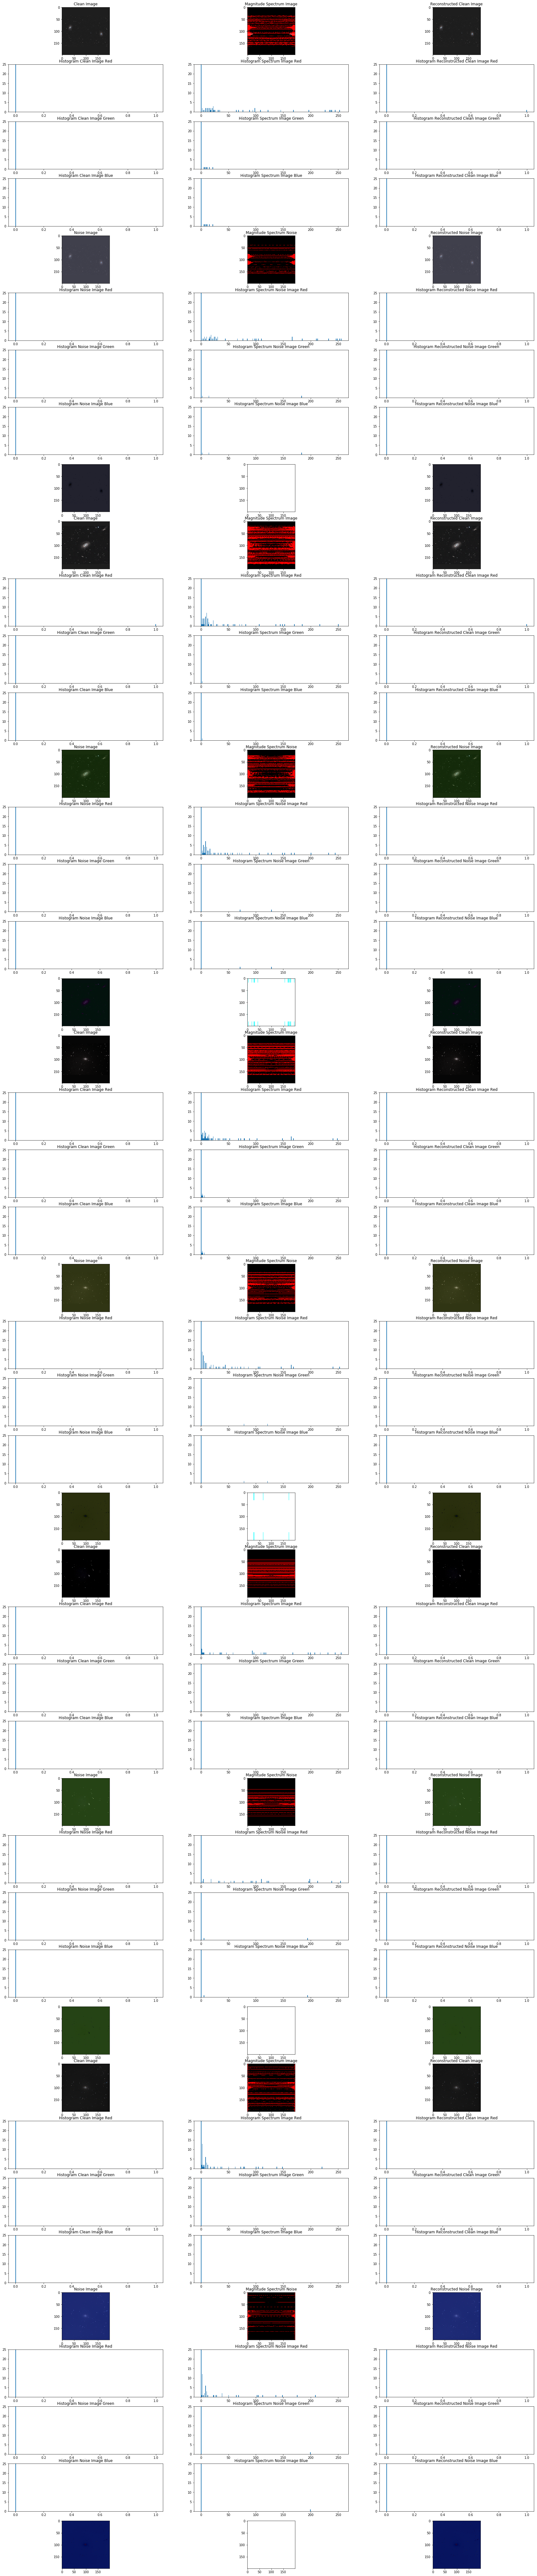

In [61]:
num_samples = 5
plt.figure(figsize=(30,30*num_samples))
for i in range(num_samples):
    image,imageBruitee = normalisation(next_batch_bruit_voile_2(7,images,199,np.float32,[1,1,1],[50,50]),[0,255],[0,1])
    image,imageBruitee = image[0,:,:,:],imageBruitee[0,:,:,:]

    import cv2
    import numpy as np
    from matplotlib import pyplot as plt

    image_fft = np.fft.fft2(image)
    imageBruitee_fft = np.fft.fft2(imageBruitee)
    image_shift = image_fft
    imageBruitee_shift = imageBruitee_fft
    # image_shift = np.fft.fftshift(image_fft)
    # imageBruitee_shift = np.fft.fftshift(imageBruitee_fft)
    image_magnitude_spectrum = 20*np.log(np.abs(image_shift))
    imageBruitee_magnitude_spectrum = 20*np.log(np.abs(imageBruitee_shift))

    def hist_color(img_array,color_index):
        img = img_array.astype(np.uint8 if np.max(img_array) < 1+10**-3 else np.float32)
        hist,bins = np.histogram(img[:,:,color_index] ,256,[0,1 if np.max(img) < 1+10**-3 else 256])
        plt.ylim((0,25))
        plt.hist(hist,bins)
        return None
    
    image_back = np.abs(np.fft.ifft2(image_shift))
    imageBruitee_back = np.abs(np.fft.ifft2(imageBruitee_shift))
    n_ligne = 9*num_samples
    tot_group_index = 3*9
    plt.subplot(n_ligne,3,i*tot_group_index+1),plt.imshow(image)
    plt.title('Clean Image')
    plt.subplot(n_ligne,3,i*tot_group_index+2),plt.imshow(image_magnitude_spectrum)
    plt.title('Magnitude Spectrum Image')
    plt.subplot(n_ligne,3,i*tot_group_index+3),plt.imshow(image_back)
    plt.title('Reconstructed Clean Image')
    
    plt.subplot(n_ligne,3,i*tot_group_index+4),hist_color(image,0)
    plt.title('Histogram Clean Image Red')
    plt.subplot(n_ligne,3,i*tot_group_index+5),hist_color(image_magnitude_spectrum,0)
    plt.title('Histogram Spectrum Image Red')
    plt.subplot(n_ligne,3,i*tot_group_index+6),hist_color(image_back,0)
    plt.title('Histogram Reconstructed Clean Image Red')
    
    plt.subplot(n_ligne,3,i*tot_group_index+7),hist_color(image,1)
    plt.title('Histogram Clean Image Green')
    plt.subplot(n_ligne,3,i*tot_group_index+8),hist_color(image_magnitude_spectrum,1)
    plt.title('Histogram Spectrum Image Green')
    plt.subplot(n_ligne,3,i*tot_group_index+9),hist_color(image_back,1)
    plt.title('Histogram Reconstructed Clean Image Green')
    
    plt.subplot(n_ligne,3,i*tot_group_index+10),hist_color(image,2)
    plt.title('Histogram Clean Image Blue')
    plt.subplot(n_ligne,3,i*tot_group_index+11),hist_color(image_magnitude_spectrum,2)
    plt.title('Histogram Spectrum Image Blue')
    plt.subplot(n_ligne,3,i*tot_group_index+12),hist_color(image_back,2)
    plt.title('Histogram Reconstructed Clean Image Blue')


    plt.subplot(n_ligne,3,i*tot_group_index+13),plt.imshow(imageBruitee)
    plt.title('Noise Image')
    plt.subplot(n_ligne,3,i*tot_group_index+14),plt.imshow(imageBruitee_magnitude_spectrum)
    plt.title('Magnitude Spectrum Noise')
    plt.subplot(n_ligne,3,i*tot_group_index+15),plt.imshow(imageBruitee_back)
    plt.title('Reconstructed Noise Image')
    
    plt.subplot(n_ligne,3,i*tot_group_index+16),hist_color(imageBruitee,0)
    plt.title('Histogram Noise Image Red')
    plt.subplot(n_ligne,3,i*tot_group_index+17),hist_color(imageBruitee_magnitude_spectrum,0)
    plt.title('Histogram Spectrum Noise Image Red')
    plt.subplot(n_ligne,3,i*tot_group_index+18),hist_color(imageBruitee_back,0)
    plt.title('Histogram Reconstructed Noise Image Red')
    
    plt.subplot(n_ligne,3,i*tot_group_index+19),hist_color(imageBruitee,1)
    plt.title('Histogram Noise Image Green')
    plt.subplot(n_ligne,3,i*tot_group_index+20),hist_color(imageBruitee_magnitude_spectrum,1)
    plt.title('Histogram Spectrum Noise Image Green')
    plt.subplot(n_ligne,3,i*tot_group_index+21),hist_color(imageBruitee_back,1)
    plt.title('Histogram Reconstructed Noise Image Green')
    
    plt.subplot(n_ligne,3,i*tot_group_index+22),hist_color(imageBruitee,2)
    plt.title('Histogram Noise Image Blue')
    plt.subplot(n_ligne,3,i*tot_group_index+23),hist_color(imageBruitee_magnitude_spectrum,2)
    plt.title('Histogram Spectrum Noise Image Blue')
    plt.subplot(n_ligne,3,i*tot_group_index+24),hist_color(imageBruitee_back,2)
    plt.title('Histogram Reconstructed Noise Image Blue')

    plt.subplot(n_ligne,3,i*tot_group_index+25),plt.imshow(np.abs(image-imageBruitee))
    plt.subplot(n_ligne,3,i*tot_group_index+26),plt.imshow(np.abs(image_magnitude_spectrum-imageBruitee_magnitude_spectrum))
    plt.subplot(n_ligne,3,i*tot_group_index+27),plt.imshow(np.abs(image_back-imageBruitee_back))
plt.show()